In [566]:
import jax
import jax_metrics as jm
import jax.numpy as jnp
from jax import grad, jit, vmap
from functools import partial
from jax import random
import os
import numpy as np
import matplotlib.pyplot as plt
# Switch off the cache 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

In [567]:
import pyodbc 

query = """

SELECT @@SERVERNAME
"""
query

'\n\nSELECT @@SERVERNAME\n'

In [568]:
import mariadb
import sys
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv ('csv_result-phpMawTba 2.csv',na_values='?')   
df = pd.DataFrame(data)
df.info()







<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              48842 non-null  int64 
 1   age             48842 non-null  int64 
 2   workclass       46043 non-null  object
 3   fnlwgt          48842 non-null  int64 
 4   education       48842 non-null  object
 5   education-num   48842 non-null  int64 
 6   marital-status  48842 non-null  object
 7   occupation      46033 non-null  object
 8   relationship    48842 non-null  object
 9   race            48842 non-null  object
 10  sex             48842 non-null  object
 11  capital-gain    48842 non-null  int64 
 12  capital-loss    48842 non-null  int64 
 13  hours-per-week  48842 non-null  int64 
 14  native-country  47985 non-null  object
 15  class           48842 non-null  object
dtypes: int64(7), object(9)
memory usage: 6.0+ MB


Vamos a realizar una limpieza de los datos

In [569]:
print(df.head(10))
#del anterior print, vemos que los valores faltantes los marca con signo '?'
#quitamos los renglones con signo '?:
df=df.dropna()



#separamos las variables categóricas para después hacerlas one-hot encoding
df_categorical=df[['workclass','education','marital-status','occupation','relationship','race','sex','native-country']]

#separamos las columnas con variables con numero
#al revisar el significado de cada columna, observamos que el significado de flnlwt no es claro, además contiene mas de 28 mil clases distintas
#entonces no usamos la columna fnlwgt
df_numerical=df[['age','education-num','capital-gain','capital-loss','hours-per-week']]

columnas=["age","education-num","capital-gain","capital-loss","hours-per-week"]
for j in columnas:
    df_numerical[j] = df_numerical[j] /df_numerical[j].abs().max()


df.loc[df["class"] == "<=50K", "class"] = 1
df.loc[df["class"] == ">50K", "class"] = -1




   id  age         workclass  fnlwgt     education  education-num  \
0   1   25           Private  226802          11th              7   
1   2   38           Private   89814       HS-grad              9   
2   3   28         Local-gov  336951    Assoc-acdm             12   
3   4   44           Private  160323  Some-college             10   
4   5   18               NaN  103497  Some-college             10   
5   6   34           Private  198693          10th              6   
6   7   29               NaN  227026       HS-grad              9   
7   8   63  Self-emp-not-inc  104626   Prof-school             15   
8   9   24           Private  369667  Some-college             10   
9  10   55           Private  104996       7th-8th              4   

       marital-status         occupation   relationship   race     sex  \
0       Never-married  Machine-op-inspct      Own-child  Black    Male   
1  Married-civ-spouse    Farming-fishing        Husband  White    Male   
2  Married-civ-spo

C:\Users\52333\AppData\Local\Temp\ipykernel_33712\1370505908.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical[j] = df_numerical[j] /df_numerical[j].abs().max()


Vamos a hacer un one hot encoder solo usando pandas

In [570]:

renglones=df['race'].shape[0]
columnas=df_categorical.shape[1]
one_hot=np.zeros(renglones)

col=0
df2=pd.DataFrame()
df3=pd.DataFrame()
df3.insert(0,'1',one_hot)
for k in range(0,columnas):
    name=df_categorical.columns[k]
    print(name)
    lista=[]
    lista=df_categorical[name].values.tolist()
    clases=df_categorical[name].unique() #un array de las distintas clases
    size_clases=len(clases)
    
    
    for i in range(size_clases):
        clase=clases[i]
        print(clase)

        for j in range(0,renglones):
            if lista[j]==clase:
                one_hot[j]=1  
        
        df2.insert(i,clase,one_hot)
        
        one_hot=np.zeros(renglones)
    df3=df3.join(df2)
    df2=pd.DataFrame()


df3.to_csv('one_hot.csv')

workclass
Private
Local-gov
Self-emp-not-inc
Federal-gov
State-gov
Self-emp-inc
Without-pay
education
11th
HS-grad
Assoc-acdm
Some-college
10th
Prof-school
7th-8th
Bachelors
Masters
5th-6th
Assoc-voc
9th
Doctorate
12th
1st-4th
Preschool
marital-status
Never-married
Married-civ-spouse
Widowed
Separated
Divorced
Married-spouse-absent
Married-AF-spouse
occupation
Machine-op-inspct
Farming-fishing
Protective-serv
Other-service
Prof-specialty
Craft-repair
Adm-clerical
Exec-managerial
Tech-support
Sales
Priv-house-serv
Transport-moving
Handlers-cleaners
Armed-Forces
relationship
Own-child
Husband
Not-in-family
Unmarried
Wife
Other-relative
race
Black
White
Other
Amer-Indian-Eskimo
Asian-Pac-Islander
sex
Male
Female
native-country
United-States
Peru
Guatemala
Mexico
Dominican-Republic
Ireland
Germany
Philippines
Thailand
Haiti
El-Salvador
Puerto-Rico
Vietnam
South
Columbia
Japan
India
Cambodia
Poland
Laos
England
Cuba
Taiwan
Italy
Canada
Portugal
China
Nicaragua
Honduras
Iran
Scotland
Jamaica

Y finalmente concatenamos nuestros dataframes y los guardamos en un CSV

In [571]:
df_clase=df['class']
#print(df_clase)
#
df_clase=df_clase.reset_index()
df_clase=df_clase.drop(['index'],axis=1)
#print(df_clase)
df_numerical=df_numerical.reset_index()
df_numerical=df_numerical.drop(['index'],axis=1)
print('este es el dataframe numerico',df_numerical)
df3=df3.reset_index()
#df3=df3.drop(['index'],axis=1)
frames=[df_clase,df_numerical,df3]

df_final=pd.concat(frames,axis=1)
df_final=df_final.drop(['index'],axis=1)
#df_final=df_final.drop(['class'],axis=1)
#df_final=df_final.drop(['1'],axis=1)
print(df_final.shape)   

df_final.to_csv('final.csv')
df_final

este es el dataframe numerico             age  education-num  capital-gain  capital-loss  hours-per-week
0      0.277778         0.4375      0.000000           0.0        0.404040
1      0.422222         0.5625      0.000000           0.0        0.505051
2      0.311111         0.7500      0.000000           0.0        0.404040
3      0.488889         0.6250      0.076881           0.0        0.404040
4      0.377778         0.3750      0.000000           0.0        0.303030
...         ...            ...           ...           ...             ...
45217  0.300000         0.7500      0.000000           0.0        0.383838
45218  0.444444         0.5625      0.000000           0.0        0.404040
45219  0.644444         0.5625      0.000000           0.0        0.404040
45220  0.244444         0.5625      0.000000           0.0        0.202020
45221  0.577778         0.5625      0.150242           0.0        0.404040

[45222 rows x 5 columns]
(45222, 105)


,class,age,education-num,capital-gain,capital-loss,hours-per-week,1,Private,Local-gov,Self-emp-not-inc,...,Jamaica,Ecuador,Yugoslavia,Hungary,Hong,Greece,Trinadad&Tobago,Outlying-US,France,Holand-Netherlands
0,1,0.277778,0.4375,0.000000,0.0,0.404040,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.422222,0.5625,0.000000,0.0,0.505051,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1,0.311111,0.7500,0.000000,0.0,0.404040,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1,0.488889,0.6250,0.076881,0.0,0.404040,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.377778,0.3750,0.000000,0.0,0.303030,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,1,0.300000,0.7500,0.000000,0.0,0.383838,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45218,-1,0.444444,0.5625,0.000000,0.0,0.404040,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45219,1,0.644444,0.5625,0.000000,0.0,0.404040,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45220,1,0.244444,0.5625,0.000000,0.0,0.202020,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora vamos a hacer las funciones necesarias para realizar el descenso del gradiente

In [622]:
class Linear_Model():
    """
    Basic Linear Regression with Ridge Regression
    """
    def __init__(self, dim: int) -> None:
        self.dim = dim
        self.key = random.PRNGKey(0)
        self.cpus = jax.devices("cpu")

    @staticmethod
    @jit
    def linear_model(X: jnp, theta: jnp) -> jnp:
        """
        Classic Linear Model. Jit has been used to accelerate the loops after the first one
        for the Gradient Descent part
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
        returns:
            f(x): the escalar estimation on vector x or the array of estimations
        """
        w = theta[:-1]
        b = theta[-1]
        return jax.numpy.matmul(X, w) + b

    def generate_theta(self):
        """
        Use the random generator at Jax to generate a random generator to instanciate
        the augmented values
        """
        keys = random.split(self.key, 1)
        return jax.numpy.vstack([random.normal(keys[0], (self.dim,1)), jax.numpy.array(0)])
        
    @partial(jit, static_argnums=(0,))
    def LSE(self, theta: jnp, X: jnp, y: jnp)-> jnp:
        """
        LSE in matrix form. We also use Jit por froze info at self to follow 
        the idea of functional programming on Jit for no side effects
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
            y: array of labels
        returns:
            the Loss function LSE under data X, labels y and theta initial estimation
        """
        return (jax.numpy.transpose(y - self.linear_model(X, theta))@(y - self.linear_model(X, theta)))[0,0]

    @partial(jit, static_argnums=(0,))
    def update(self, theta: jnp, X: jnp, y: jnp, lr):
        """
        Update makes use of the autograd at Jax to calculate the gradient descent.
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
            y: array of labels
            lr: Learning rate for Gradient Descent
        returns:
            the step update w(n+1) = w(n)-δ(t)𝜵L(w(n))        
        """
        return theta - lr * jax.grad(self.LSE)(theta, X, y)

        
    @partial(jit, static_argnums=(0,))
    def estimate_grsl(self, X, theta):
        """
        Estimation for the Gradient Descent version
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
        return:
            Estimation of data X under linear model
        """
        w = theta[:-1]
        b = theta[-1]
        return X@w+b
    
    def precision(self, y, y_hat):
        """
        Precision
        args:
            y: Real Labels
            y_hat: estimated labels
        return TP/(TP+FP)
        """
        TP=0
        FP=0
        for i in range(len(y)):
            if(y_hat[i]>0 and y[i]>0):
                TP+=1
            if(y_hat[i]>0 and y[i]<0):
                FP+=1

        #TP = sum(y_hat[y>0]>0)
        #FP = sum(y_hat[y>0]<0)
        precision_cpu = jax.jit(lambda x: x, device=self.cpus[0])(TP/(TP+FP))
        return float(precision_cpu)
    def accuracy(self, y, y_hat):
        """
        Precision
        args:
            y: Real Labels
            y_hat: estimated labels
        return TP/(TP+FP)
        """
        TP=0
        TN=0
        FP=0
        FN=0
        for i in range(len(y)):
            if(y_hat[i]>0 and y[i]>0) :
                TP+=1
            if(y_hat[i]<0 and y[i]<0):
                TN+=1
            if(y_hat[i]<0 and y[i]>0):
                FN+=1
            if(y_hat[i]>0 and y[i]<0):
                FP+=1

        #TP = sum(y_hat[y>0]>0)
        #FP = sum(y_hat[y>0]<0)
        accuracy_cpu = jax.jit(lambda x: x, device=self.cpus[0])((TP+TN)/(TP+FP+TN+FN))
        return float(accuracy_cpu)
    
    
    def gradient_descent(self, theta: jnp,  X: jnp, y: jnp, n_steps: int, lr = 0.001):
        """
        Gradient Descent Loop for the LSE Linear Model
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
            y: array of labels
            n_steps: number steps for the Gradient Loop
            lr: Learning rate for Gradient Descent   
        return:
            Updated Theta
        """
        for i in range(n_steps):
            theta = self.update(theta, X, y, lr)
        return theta
    ######################################################################################################
    #########vamos a hacer la implementación de la regularización de Ridge##################################

    def generate_canonicalRidge_estimator(self, X: jnp, y:jnp,la:jnp) -> jnp:
        """
        Cannonical LSE error solution for the Linearly separable classes 
        args:
            X: Data array at the GPU or CPU
            y: Label array at the GPU 
        returns:
            w: Weight array at the GPU or CPU
        """
        XX=jax.numpy.transpose(X)@X
        dimension=int(jnp.shape(XX)[0])
        I=jax.numpy.identity(dimension)
        return  jax.numpy.linalg.inv(XX+la*I)@jax.numpy.transpose(X)@y
    
    @staticmethod
    def estimate_cannonicalRidge(X: jnp, w: jnp)->jnp:
        """
        Estimation for the Gradient Descent version
        args:
            X: Data array at the GPU or CPU
            w: Parameter w under extended space
        return:
            Estimation of data X under cannonical solution
        """
        return X@w

Ahora vamos a cargar nuestros datos limpiados en jnp arrays

In [590]:

X=df_final[df_final.columns[1:]].to_numpy()
y=df_clase.to_numpy()
y=y.astype(int)
dim=int(X.shape[1])
print(dim)
X=jax.numpy.asarray(X)
y=jax.numpy.asarray(y)
y.shape

104


(45222, 1)

In [623]:
model=Linear_Model(dim)
theta = model.generate_theta()
theta = model.gradient_descent(theta, X, y, 10000, lr = 0.0000001)
theta.shape

(105, 1)

In [627]:
y_est=y[:500]
X_est=X[:500]
print(X_est.shape)
y_hat=model.estimate_grsl(X_est,theta)
recall=model.precision(y_est,y_hat)
accuracy=model.accuracy(y_est, y_hat)
accuracy


(500, 104)


0.7960000038146973

In [612]:
recall

0.6710000038146973

Por último vamos a aplicar la version regularizada

In [628]:
#primero necesitamos la X aumentada
X_e = np.hstack([X_est, np.ones((500,1))])

0.8740919828414917 0.01
0.8740919828414917 0.02
0.8740919828414917 0.03
0.8740919828414917 0.04
0.8740919828414917 0.05
0.8740919828414917 0.060000000000000005
0.8737863898277283 0.07
0.8737863898277283 0.08
0.8737863898277283 0.09
0.8737863898277283 0.09999999999999999
0.8737863898277283 0.10999999999999999
0.8737863898277283 0.11999999999999998
0.8716707229614258 0.12999999999999998
0.8716707229614258 0.13999999999999999
0.8716707229614258 0.15
0.8716707229614258 0.16
0.8716707229614258 0.17
0.8716707229614258 0.18000000000000002
0.8716707229614258 0.19000000000000003
0.8716707229614258 0.20000000000000004
0.8716707229614258 0.21000000000000005
0.8716707229614258 0.22000000000000006
0.8716707229614258 0.23000000000000007
0.8716707229614258 0.24000000000000007
0.8716707229614258 0.25000000000000006


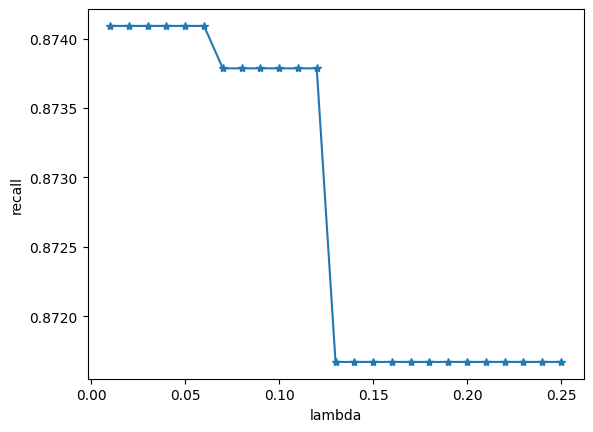

In [631]:
#vamos a buscar lambda en un grid de puntos[0,0.5,1,...]
l=0
max_steps=25
l_vec=np.zeros(int(max_steps))
precision=np.zeros(int(max_steps))
for i in range(max_steps):
    l=l+0.01
    l_vec[i]=l
    wR = model.generate_canonicalRidge_estimator(X_e, y_est,l)
    y_hatR = model.estimate_cannonicalRidge(X_e, wR)
    precision[i]=model.precision(y_est, y_hatR)
    print(precision[i],l)

plt.plot(l_vec,precision,'*-')
plt.xlabel('lambda')
plt.ylabel('recall')
plt.show()
